#**TASK III (MULTIMODAL: IMAGE + TEXT BASED CLASSIFICATION)**

##**SETTING UP THE SYSTEM**

In [1]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.1 MB/s eta 0:00:00


In [4]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Imports required

import os
import torch
import pickle
import requests
import transformers

import numpy as np
import tensorflow as tf
import pandas as pd

In [6]:
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from google.colab import drive
from matplotlib import pyplot as plt

from tensorflow.keras import layers

# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Dropout
from transformers import AutoTokenizer, TFAutoModel

In [7]:
# Checking if gpu is available and runnig it on the gpu

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

CPU


In [8]:
# Mounting google drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**SAVING DATA IN LISTS**

In [ ]:
image_size = (224, 224)

In [ ]:
image_file_path = '/content/gdrive/MyDrive/DL_Assignment4'

train_info = '/content/gdrive/MyDrive/DL_Assignment4/train.jsonl'
val_info = '/content/gdrive/MyDrive/DL_Assignment4/dev_seen.jsonl'
test_info ='/content/gdrive/MyDrive/DL_Assignment4/test_seen.jsonl'

In [ ]:
train_df = pd.read_json(train_info, lines=True)
val_df = pd.read_json(val_info, lines=True)
test_df = pd.read_json(test_info, lines=True)

In [ ]:
train_df['img'] = image_file_path + '/' + train_df['img']
val_df['img'] = image_file_path + '/' + val_df['img']
test_df['img'] = image_file_path + '/' + test_df['img']

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

In [ ]:
train_label_data = np.array(train_df['label'].tolist())
val_label_data = np.array(val_df['label'].tolist())
test_label_data = np.array(test_df['label'].tolist())

In [ ]:
train_text_data = np.array(train_df['text'].tolist())
val_text_data = np.array(val_df['text'].tolist())
test_text_data = np.array(test_df['text'].tolist())

In [ ]:
# Load and preprocess the image data

def load_and_preprocess_image(file_path):
    img = Image.open(file_path)
    img = img.resize(image_size)
    return img

In [ ]:
print('TRAIN IMAGES')
train_image_data = []
for i, file_path in tqdm(enumerate(train_df['img'])):
    img = load_and_preprocess_image(file_path)
    train_image_data.append(img)

print('VALIDATION IMAGES')
val_image_data = []
for i, file_path in tqdm(enumerate(val_df['img'])):
    img = load_and_preprocess_image(file_path)
    val_image_data.append(img)

print('TEST IMAGES')
test_image_data = []
for i, file_path in tqdm(enumerate(test_df['img'])):
    img = load_and_preprocess_image(file_path)
    test_image_data.append(img)

TRAIN IMAGES


8500it [03:30, 40.38it/s]


VALIDATION IMAGES


500it [00:12, 39.42it/s]


TEST IMAGES


1000it [00:24, 40.19it/s]


In [ ]:
# Save the image_data lists to Google Drive

with open('/content/gdrive/MyDrive/DL_Assignment4/train_image_data.pickle', 'wb') as f:
    pickle.dump(train_image_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/val_image_data.pickle', 'wb') as f:
    pickle.dump(val_image_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/test_image_data.pickle', 'wb') as f:
    pickle.dump(test_image_data, f)

In [ ]:
# Save the text_data lists to Google Drive

with open('/content/gdrive/MyDrive/DL_Assignment4/train_text_data.pickle', 'wb') as f:
    pickle.dump(train_text_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/val_text_data.pickle', 'wb') as f:
    pickle.dump(val_text_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/test_text_data.pickle', 'wb') as f:
    pickle.dump(test_text_data, f)

In [ ]:
# Save the text_data lists to Google Drive

with open('/content/gdrive/MyDrive/DL_Assignment4/train_label_data.pickle', 'wb') as f:
    pickle.dump(train_label_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/val_label_data.pickle', 'wb') as f:
    pickle.dump(val_label_data, f)

with open('/content/gdrive/MyDrive/DL_Assignment4/test_label_data.pickle', 'wb') as f:
    pickle.dump(test_label_data, f)

##**PART 1**

In [10]:
# Load the saved images from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/train_image_data.pickle', 'rb') as f:
    img_train = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/val_image_data.pickle', 'rb') as f:
    img_val = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/test_image_data.pickle', 'rb') as f:
    img_test = pickle.load(f)


# Load the saved text from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/train_text_data.pickle', 'rb') as f:
    txt_train = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/val_text_data.pickle', 'rb') as f:
    txt_val = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/test_text_data.pickle', 'rb') as f:
    txt_test = pickle.load(f)


# Load the saved labels from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/train_label_data.pickle', 'rb') as f:
    lbl_train = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/val_label_data.pickle', 'rb') as f:
    lbl_val = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/DL_Assignment4/test_label_data.pickle', 'rb') as f:
    lbl_test = pickle.load(f)

In [11]:
arr_img_train = np.array(img_train)
arr_txt_train = txt_train
arr_lbl_train = lbl_train

arr_img_val = np.array(img_val)
arr_txt_val = txt_val
arr_lbl_val = lbl_val

arr_img_test = np.array(img_test)
arr_txt_test = txt_test
arr_lbl_test = lbl_test

<ipython-input-11-cb946943eceb>:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr_img_train = np.array(img_train)
<ipython-input-11-cb946943eceb>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_img_train = np.array(img_train)
<ipython-input-11-cb946943eceb>:5: FutureWarning: The input object of type 'Image' is an array-like implementing one of the correspondin

In [13]:
type(arr_img_train[0])

PIL.Image.Image

In [12]:
arr_img_train.shape

(8500,)

## Preprocess images

In [14]:
from PIL import Image
import keras.utils as image

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 4s 0us/step


In [16]:
def encode(PIL_img):

    img = PIL_img.resize((299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) 

    fea_vec = model_new.predict(x) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    
    return fea_vec

In [ ]:
arr_img_train_enc = []
remove = []
i = 0

for img in arr_img_train:
  try:
    arr_img_train_enc.append( encode(img) )

  except:
    remove.append(i)
    i += 1
    continue

  i += 1

In [18]:
len(remove)

4

In [19]:
arr_img_train = np.delete(arr_img_train, remove)
arr_txt_train = np.delete(arr_txt_train, remove)
arr_lbl_train = np.delete(arr_lbl_train, remove)

In [20]:
with open('/content/gdrive/MyDrive/DL/A4/train_image_encd.pickle', 'wb') as f:
    pickle.dump(arr_img_train_enc, f)

In [29]:
arr_lbl_train.shape

(8496,)

In [ ]:
arr_img_test_enc = []
remove = []
i = 0

for img in arr_img_test:

  try:
    arr_img_test_enc.append( encode(img) )
  except:
    remove.append(i)
    i += 1
    continue

  i += 1

In [22]:
arr_img_test = np.delete(arr_img_test, remove)
arr_txt_test = np.delete(arr_txt_test, remove)
arr_lbl_test = np.delete(arr_lbl_test, remove)

In [23]:
with open('/content/gdrive/MyDrive/DL/A4/test_image_encd.pickle', 'wb') as f:
    pickle.dump(arr_img_test_enc, f)

In [24]:
arr_img_test.shape

(1000,)

In [ ]:
arr_img_val_enc = []
remove = []
i = 0
for img in arr_img_val:

  try:
    arr_img_val_enc.append( encode(img) )
  except:
    remove.append(i)
    i += 1
    continue

  i += 1

In [82]:
remove

[198]

In [83]:
arr_img_val = np.delete(arr_img_val, remove)
arr_txt_val = np.delete(arr_txt_val, remove)
arr_lbl_val = np.delete(arr_lbl_val, remove)

In [84]:
arr_img_val.shape

(499,)

In [85]:
with open('/content/gdrive/MyDrive/DL/A4/val_image_encd.pickle', 'wb') as f:
    pickle.dump(arr_img_val_enc, f)

## Preprocess text

In [33]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.9 MB/s eta 0:00:00


In [34]:
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [36]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output'].numpy()

In [61]:
# arr_text_train_emb = get_sentence_embeding(arr_txt_train)
batch_size = 32
num_batches = (len(arr_txt_train) + batch_size - 1) // batch_size  # Calculate number of batches

arr_txt_train_emb = np.empty((0, 768))
# Loop over batches

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = (i+1) * batch_size
    batch_sentences = arr_txt_train[batch_start:batch_end]  # Get batch of sentences
    batch_embeddings = get_sentence_embeding(batch_sentences)  # Compute embeddings for batch
    # Do something with the embeddings, e.g. store them in a list or numpy array
    arr_txt_train_emb = np.append(arr_txt_train_emb, batch_embeddings, axis = 0)

In [63]:
arr_txt_train_emb.shape

(8496, 768)

In [62]:
with open('/content/gdrive/MyDrive/DL/A4/train_txt_emb.pickle', 'wb') as f:
    pickle.dump(arr_txt_train_emb, f)

In [46]:
arr_txt_train.shape

(8496,)

In [44]:
with open('/content/gdrive/MyDrive/DL/A4/val_lbl.pickle', 'wb') as f:
    pickle.dump(arr_lbl_val, f)

In [91]:
arr_txt_test_emb = get_sentence_embeding(arr_txt_test)

In [92]:
with open('/content/gdrive/MyDrive/DL/A4/test_txt_emb.pickle', 'wb') as f:
    pickle.dump(arr_txt_test_emb, f)

In [93]:
arr_txt_val_emb = get_sentence_embeding(arr_txt_val)

In [94]:
with open('/content/gdrive/MyDrive/DL/A4/val_txt_emb.pickle', 'wb') as f:
    pickle.dump(arr_txt_val_emb, f)

## Loading embeddings

In [23]:
# Load the saved images from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/A4/train_image_encd.pickle', 'rb') as f:
    arr_img_train_enc = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/val_image_encd.pickle', 'rb') as f:
    arr_img_val_enc = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/test_image_encd.pickle', 'rb') as f:
    arr_img_test_enc = pickle.load(f)


# Load the saved text from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/A4/train_txt_emb.pickle', 'rb') as f:
    arr_txt_train_emb = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/val_txt_emb.pickle', 'rb') as f:
    arr_txt_val_emb = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/test_txt_emb.pickle', 'rb') as f:
    arr_txt_test_emb = pickle.load(f)


# Load the saved labels from train, val and test list from Google Drive

with open('/content/gdrive/MyDrive/DL/A4/train_lbl.pickle', 'rb') as f:
    arr_lbl_train = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/val_lbl.pickle', 'rb') as f:
    arr_lbl_val = pickle.load(f)

with open('/content/gdrive/MyDrive/DL/A4/test_lbl.pickle', 'rb') as f:
    arr_lbl_test = pickle.load(f)

In [24]:
arr_img_train_enc = np.array(arr_img_train_enc)
arr_img_test_enc = np.array(arr_img_test_enc)
arr_img_val_enc = np.array(arr_img_val_enc)

In [25]:
arr_lbl_val = np.delete(arr_lbl_val, 198 )

## multi-model

In [26]:
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import add
from keras.models import Model

In [35]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(1024, activation='relu')(fe1)
fe3 = Dense(256, activation='relu')(fe1)


inputs2 = Input(shape=(768,))
se1 = Reshape((768, 1))(inputs2)  # add a timestep dimension
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe3,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(128, activation='relu')(decoder2)
# decoder4 = Dense(64, activation='relu')(decoder3)
# decoder5 = Dense(32, activation='relu')(decoder4)
outputs = Dense(1, activation='sigmoid')(decoder3)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 768, 1)       0           ['input_8[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_7[0][0]']                
                                                                                            

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define the checkpoint filepath
checkpoint_filepath = '/conten/gdrive/MyDrive/DL/A4/multi_model/additive.h5'

# define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    
    checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)


In [ ]:
history = model.fit( x =  [ arr_img_train_enc,  arr_txt_train_emb ], y = arr_lbl_train,
          epochs=5, batch_size=64,
          validation_data=([arr_img_val_enc, arr_txt_val_emb], arr_lbl_val), verbose = 1, callbacks=[checkpoint], validation_batch_size=64)


In [ ]:
import matplotlib.pyplot as plt

# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [119]:
model.save('/content/gdrive/MyDrive/DL/A4/multi_model.h5')

In [30]:
model.evaluate( [arr_img_test_enc, arr_txt_test_emb], arr_lbl_test, batch_size= 64)

16/16 [==============================] - 1s 63ms/step - loss: 0.7221 - accuracy: 0.4900


[0.7220821976661682, 0.49000000953674316]

## Early fusion

In [140]:
inputs1 = Input(shape=(2048,))
inputs2 = Input(shape=(768,))

# Concatenate the inputs
concat_inputs = concatenate([inputs1, inputs2])

# Early fusion: process the concatenated inputs
fe1 = Dropout(0.5)(concat_inputs)
fe2 = Dense(512, activation='relu')(fe1)
ef3 = Reshape((1, 512))(fe2) # add a timestep dimension
ef4 = LSTM(512)(ef3)
ef5 = LSTM(216)(ef4)
outputs = Dense(1, activation='sigmoid')(ef5)

early_fusion = Model(inputs=[inputs1, inputs2], outputs=outputs)
early_fusion.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 2816)         0           ['input_25[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 dropout_13 (Dropout)           (None, 2816)         0           ['concatenate_7[0][0]']   

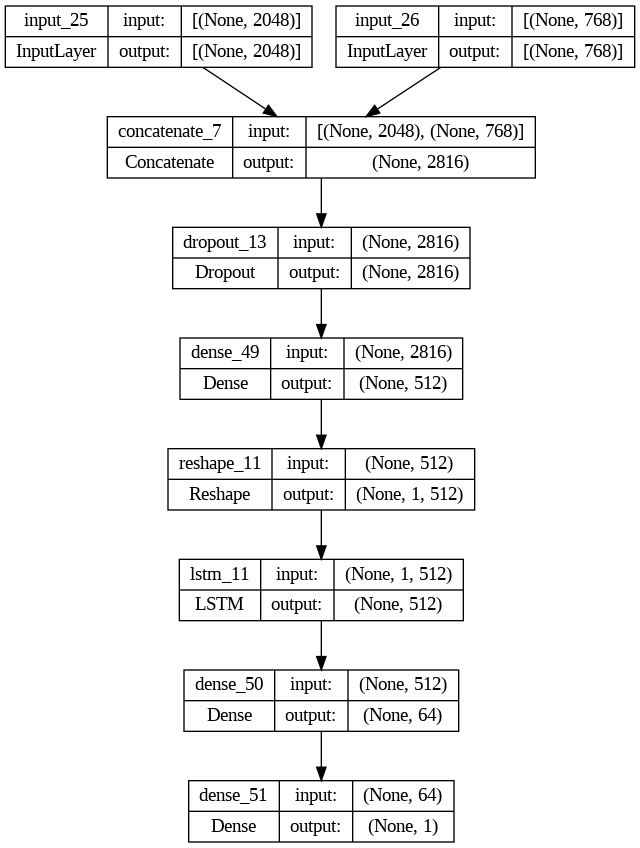

In [141]:
from keras.utils import plot_model

# ... define your model ...

plot_model(early_fusion, show_shapes=True)
plot_model(early_fusion, show_shapes=True, to_file='early_fusion.png')

In [142]:
early_fusion.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [143]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/DL/A4/multi_model/early_fusion2.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [148]:
history = early_fusion.fit(x=[arr_img_train_enc, arr_txt_train_emb], y=arr_lbl_train,
           epochs=10, batch_size=64,
           validation_data = ([arr_img_val_enc, arr_txt_val_emb], arr_lbl_val), verbose=1, callbacks=[checkpoint], validation_batch_size=64)

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.6758
Epoch 1: val_accuracy did not improve from 0.56513
133/133 [==============================] - 15s 91ms/step - loss: 0.6041 - accuracy: 0.6758 - val_loss: 0.7473 - val_accuracy: 0.5090
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.6791
Epoch 2: val_accuracy did not improve from 0.56513
133/133 [==============================] - 21s 158ms/step - loss: 0.5997 - accuracy: 0.6791 - val_loss: 0.7104 - val_accuracy: 0.5291
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.6775
Epoch 3: val_accuracy did not improve from 0.56513
133/133 [==============================] - 11s 84ms/step - loss: 0.5929 - accuracy: 0.6775 - val_loss: 0.7289 - val_accuracy: 0.5471
Epoch 4/10
133/133 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.6857
Epoch 4: val_accuracy did not improve from 0.56513
133/133 [===

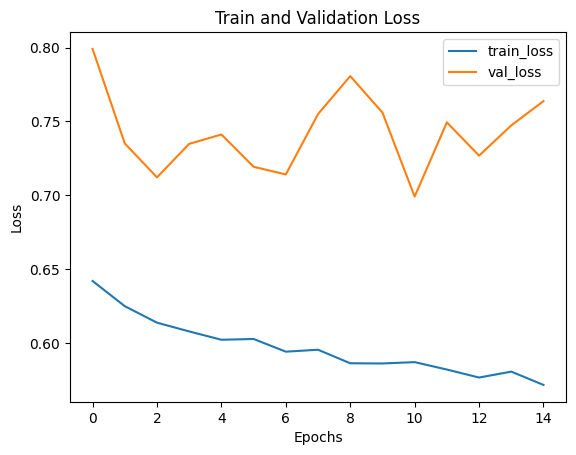

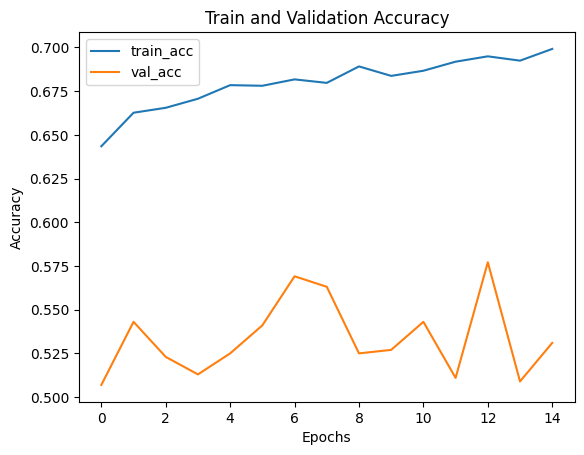

In [84]:
import matplotlib.pyplot as plt

# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [146]:
from keras.models import load_model
early_fusion = load_model('/content/gdrive/MyDrive/DL/A4/multi_model/early_fusion2.hdf5')

In [149]:
early_fusion.evaluate( [arr_img_test_enc, arr_txt_test_emb], arr_lbl_test, batch_size= 64)

16/16 [==============================] - 0s 28ms/step - loss: 0.7226 - accuracy: 0.5540


[0.7225942611694336, 0.5540000200271606]

In [150]:
Y_test_pred = early_fusion.predict([[arr_img_test_enc, arr_txt_test_emb]])

Y_test_seen_pred = Y_test_pred.reshape((1000,))
Y_test_seen_pred = np.array( Y_test_seen_pred >= 0.5)

from sklearn.metrics import classification_report
print(classification_report(arr_lbl_test, Y_test_seen_pred))

32/32 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.54      0.82      0.65       510
           1       0.60      0.27      0.38       490

    accuracy                           0.55      1000
   macro avg       0.57      0.55      0.51      1000
weighted avg       0.57      0.55      0.52      1000



## LateFusion Fusion

In [88]:
from keras.layers import Dot
import keras.backend as K

inputs1 = Input(shape=(2048,))
# fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(1024, activation='relu')(inputs1)
fe3 = Dense(64, activation='relu')(fe2)

inputs2 = Input(shape=(768,))
se1 = Reshape((768, 1))(inputs2)  # add a timestep dimension
# se2 = Dropout(0.5)(se1)
se3 = LSTM(64)(se1)

# # Perform tensor fusion using the Dot layer
# fusion = Dot(axes=1)([fe3, se3])
# transpose fe3
# Perform tensor fusion using matrix multiplication

fusion = concatenate([se3, fe3])

decoder2 = Dense(256, activation='relu')(fusion)
decoder4 = Dense(128, activation='relu')(decoder2)
outputs = Dense(1, activation='sigmoid')(decoder4)

late_fusion = Model(inputs=[inputs1, inputs2], outputs=outputs)
late_fusion.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 reshape_7 (Reshape)            (None, 768, 1)       0           ['input_18[0][0]']               
                                                                                                  
 dense_31 (Dense)               (None, 1024)         2098176     ['input_17[0][0]']               
                                                                                            

In [89]:
late_fusion.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/DL/A4/multi_model/late_fusion_fusion.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [92]:
history = late_fusion.fit( x =  [ arr_img_train_enc,  arr_txt_train_emb ], y = arr_lbl_train,
          epochs=10, batch_size=32,
          validation_data=([arr_img_val_enc, arr_txt_val_emb], arr_lbl_val), verbose = 1, validation_batch_size=64, callbacks = [checkpoint])


Epoch 1/10
266/266 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6378
Epoch 1: val_accuracy improved from -inf to 0.50501, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/late_fusion_fusion.hdf5
266/266 [==============================] - 124s 452ms/step - loss: 0.6521 - accuracy: 0.6378 - val_loss: 0.7325 - val_accuracy: 0.5050
Epoch 2/10
266/266 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.6455
Epoch 2: val_accuracy improved from 0.50501 to 0.50902, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/late_fusion_fusion.hdf5
266/266 [==============================] - 120s 452ms/step - loss: 0.6417 - accuracy: 0.6455 - val_loss: 0.7455 - val_accuracy: 0.5090
Epoch 3/10
266/266 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.6442
Epoch 3: val_accuracy improved from 0.50902 to 0.51303, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/late_fusion_fusion.hdf5
266/266 [======================

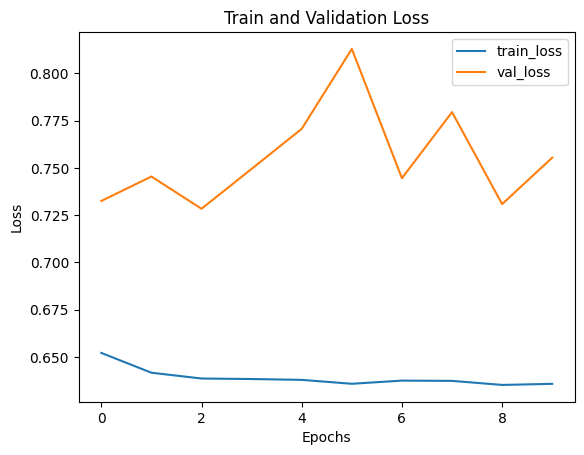

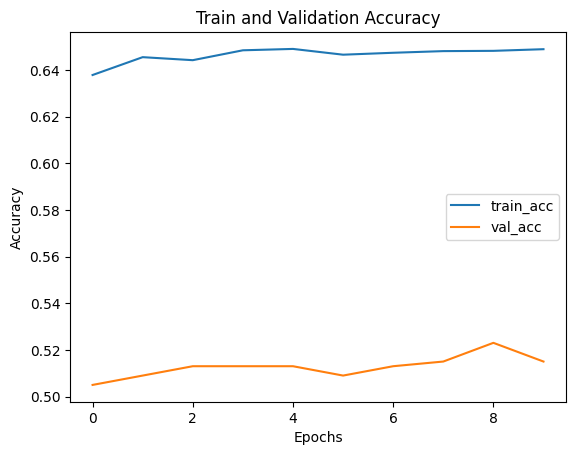

In [93]:
import matplotlib.pyplot as plt

# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [96]:
from keras.models import load_model
early_fusion = load_model('/content/gdrive/MyDrive/DL/A4/multi_model/late_fusion_fusion.hdf5')

In [97]:
late_fusion.evaluate( [arr_img_test_enc, arr_txt_test_emb], arr_lbl_test, batch_size= 64)

16/16 [==============================] - 3s 182ms/step - loss: 0.7484 - accuracy: 0.5160


[0.7484496831893921, 0.515999972820282]

## loading tensor data

In [10]:
train_img, train_txt, arr_lbl_train, test_img, test_txt, arr_lbl_test, val_img, val_txt, arr_lbl_val = pickle.load(open('/content/gdrive/MyDrive/DL/A4/tsne.pickle', 'rb'))

## TSNE

In [45]:
# Define a new model with inputs from the previous model and outputs from se3 and fe3 layers
activation_model = Model(inputs=tf_model.inputs, outputs=[fe3, se3])
# Get the activations for se3 and fe3 on a test set
test_img, test_txt = activation_model.predict([arr_img_test_enc, arr_txt_test_emb])
train_img, train_txt = activation_model.predict([arr_img_train_enc, arr_txt_train_emb])
val_img, val_txt = activation_model.predict([arr_img_val_enc, arr_txt_val_emb])

16/16 [==============================] - 2s 132ms/step


In [51]:
val_txt.shape

(499, 64)

In [49]:
pickle.dump( ( train_img, train_txt, arr_lbl_train, test_img, test_txt, arr_lbl_test, val_img, val_txt, arr_lbl_val), open('/content/gdrive/MyDrive/DL/A4/tsne.pickle', 'wb'))

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [52]:
model = TSNE(n_components = 2, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data = model.fit_transform(test_txt)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.009203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.558964
[t-SNE] KL divergence after 1000 iterations: 0.278225


In [54]:
tsne_data = np.vstack((tsne_data.T, arr_lbl_test)).T
tsne_df = pd.DataFrame(data = tsne_data, columns =("Dim_1", "Dim_2", "label"))

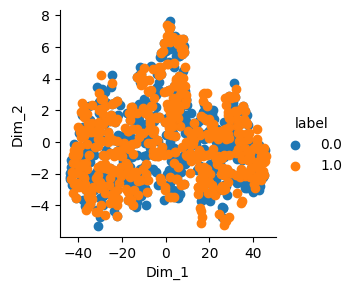

<Figure size 1500x1500 with 0 Axes>

In [56]:
sns.FacetGrid(tsne_df, hue ="label").map( plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.figure(figsize=(15, 15))
plt.show()

In [58]:
model2 = TSNE(n_components = 3, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data2 = model2.fit_transform(test_txt)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.009203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.316601
[t-SNE] KL divergence after 1000 iterations: 0.191149


In [59]:
tsne_data2 = np.vstack((tsne_data2.T, arr_lbl_test)).T
tsne_df2 = pd.DataFrame(data = tsne_data2, columns =("Dim_1", "Dim_2", "Dim_3", "label"))

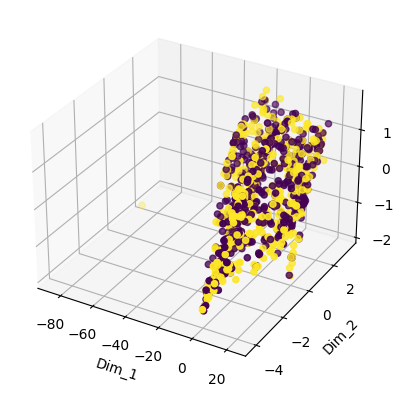

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = tsne_df2['Dim_1']
y = tsne_df2['Dim_2']
z = tsne_df2['Dim_3']
colors = tsne_df2['label']

ax.scatter(x, y, z, c=colors, cmap='viridis')
ax.set_xlabel('Dim_1')
ax.set_ylabel('Dim_2')
ax.set_zlabel('Dim_3')

plt.show()


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.677012
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.677490
[t-SNE] KL divergence after 1000 iterations: 1.540403


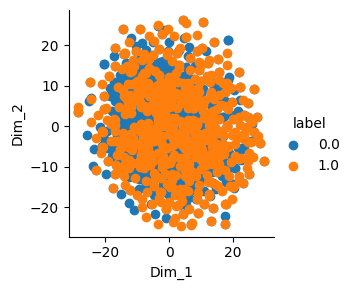

<Figure size 1500x1500 with 0 Axes>

In [61]:
model = TSNE(n_components = 2, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data = model.fit_transform(test_img)
tsne_data = np.vstack((tsne_data.T, arr_lbl_test)).T
tsne_df = pd.DataFrame(data = tsne_data, columns =("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue ="label").map( plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.figure(figsize=(15, 15))
plt.show()

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.677012
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.882858
[t-SNE] KL divergence after 1000 iterations: 1.775853


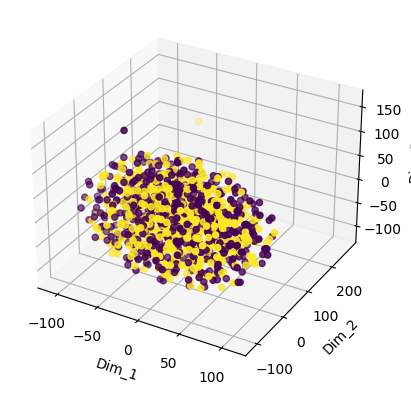

In [62]:
model2 = TSNE(n_components = 3, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data2 = model2.fit_transform(test_img)
tsne_data2 = np.vstack((tsne_data2.T, arr_lbl_test)).T
tsne_df2 = pd.DataFrame(data = tsne_data2, columns =("Dim_1", "Dim_2", "Dim_3", "label"))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = tsne_df2['Dim_1']
y = tsne_df2['Dim_2']
z = tsne_df2['Dim_3']
colors = tsne_df2['label']

ax.scatter(x, y, z, c=colors, cmap='viridis')
ax.set_xlabel('Dim_1')
ax.set_ylabel('Dim_2')
ax.set_zlabel('Dim_3')

plt.show()

## FUSION

In [99]:
def tensor_fusion(se3, fe3):

  result = []
  batch , col = se3.shape

  for i in range(batch):
    
    ma = se3[i].reshape((1,col))
    b = np.ones( ( ma.shape[0], 1), dtype = int)
    ma = np.hstack((ma, b))

    mb = fe3[i].reshape((1,col))
    b = np.ones(( mb.shape[0], 1), dtype = int)
    mb = np.hstack((mb, b))

    fus = ma.T@mb
    fus = fus.flatten()
    result.append(fus)

  return np.array(result)

tensor_fusion( np.array([[1,2], [3,4]]), np.array( [ [ 1,2 ], [2,3]]))

array([[ 1,  2,  1,  2,  4,  2,  1,  2,  1],
       [ 6,  9,  3,  8, 12,  4,  2,  3,  1]])

In [100]:
train_fusion = tensor_fusion(train_img, train_txt)
test_fusion = tensor_fusion(test_img, test_txt)
val_fusion = tensor_fusion(val_img, val_txt)

In [101]:
val_fusion.shape

(499, 4225)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.683450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.803841
[t-SNE] KL divergence after 1000 iterations: 1.523717


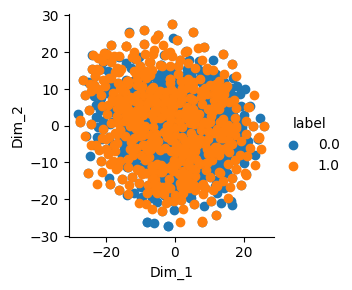

<Figure size 1500x1500 with 0 Axes>

In [104]:
model = TSNE(n_components = 2, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data = model.fit_transform(test_fusion)
tsne_data = np.vstack((tsne_data.T, arr_lbl_test)).T
tsne_df = pd.DataFrame(data = tsne_data, columns =("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue ="label").map( plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.figure(figsize=(15, 15))
plt.show()

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.683450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.133736
[t-SNE] KL divergence after 1000 iterations: 1.750469


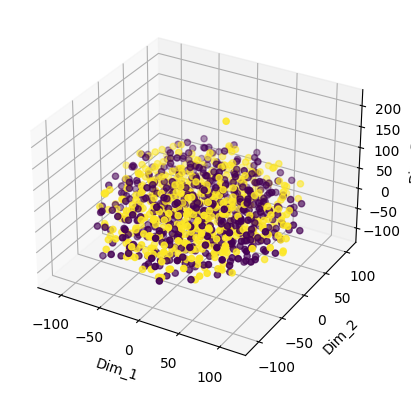

In [105]:
model2 = TSNE(n_components = 3, random_state = 0, perplexity = 70 , n_iter = 1000, learning_rate= 200, verbose = 1)
tsne_data2 = model2.fit_transform(test_fusion)
tsne_data2 = np.vstack((tsne_data2.T, arr_lbl_test)).T
tsne_df2 = pd.DataFrame(data = tsne_data2, columns =("Dim_1", "Dim_2", "Dim_3", "label"))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = tsne_df2['Dim_1']
y = tsne_df2['Dim_2']
z = tsne_df2['Dim_3']
colors = tsne_df2['label']

ax.scatter(x, y, z, c=colors, cmap='viridis')
ax.set_xlabel('Dim_1')
ax.set_ylabel('Dim_2')
ax.set_zlabel('Dim_3')

plt.show()

In [114]:
inputs1 = Input(shape=(4225,))
# fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(2804, activation='relu')(inputs1)
fe3 = Dense(784, activation='relu')(fe2)
fe4 = Dense(256, activation = 'relu')(fe3)
fe5 = Dense(64, activation = 'relu')(fe4)
output = Dense(1, activation = 'sigmoid', name = 'output')(fe5)

tensor_fusion = Model( inputs = [inputs1], outputs = output)
tensor_fusion.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 4225)]            0         
                                                                 
 dropout_10 (Dropout)        (None, 4225)              0         
                                                                 
 dense_40 (Dense)            (None, 512)               2163712   
                                                                 
 reshape_8 (Reshape)         (None, 1, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 256)               787456    
                                                                 
 dense_42 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,951,425
Trainable params: 2,951,425
Non-tra

In [115]:
tensor_fusion.compile(optimizer='adam',  loss='binary_crossentropy',  metrics=['accuracy'])

In [116]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/DL/A4/multi_model/tensor_fusion.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [117]:
history = tensor_fusion.fit(train_fusion, arr_lbl_train, epochs = 8, batch_size = 32, validation_data = ( val_fusion, arr_lbl_val), validation_batch_size=64, callbacks = [checkpoint])

Epoch 1/8
265/266 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.6442
Epoch 1: val_accuracy improved from -inf to 0.50902, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/tensor_fusion.hdf5
266/266 [==============================] - 17s 51ms/step - loss: 0.6451 - accuracy: 0.6441 - val_loss: 0.7457 - val_accuracy: 0.5090
Epoch 2/8
266/266 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6469
Epoch 2: val_accuracy improved from 0.50902 to 0.51102, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/tensor_fusion.hdf5
266/266 [==============================] - 14s 53ms/step - loss: 0.6388 - accuracy: 0.6469 - val_loss: 0.7602 - val_accuracy: 0.5110
Epoch 3/8
266/266 [==============================] - ETA: 0s - loss: 0.6361 - accuracy: 0.6508
Epoch 3: val_accuracy improved from 0.51102 to 0.51303, saving model to /content/gdrive/MyDrive/DL/A4/multi_model/tensor_fusion.hdf5
266/266 [==============================] - 15s 55ms/s

In [118]:
tensor_fusion.evaluate(test_fusion, arr_lbl_test)

32/32 [==============================] - 1s 15ms/step - loss: 0.7385 - accuracy: 0.5240


[0.7384780645370483, 0.5239999890327454]

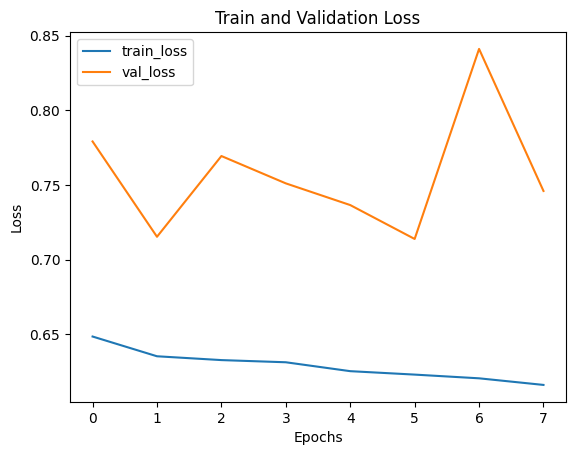

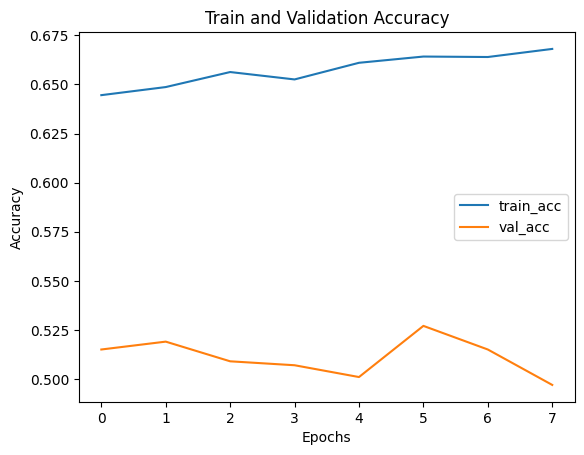

In [111]:
import matplotlib.pyplot as plt

# Plot train and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot train and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [119]:
from keras.models import load_model
tensor_fusion = load_model('/content/gdrive/MyDrive/DL/A4/multi_model/tensor_fusion.hdf5')

In [120]:
tensor_fusion.evaluate(test_fusion, arr_lbl_test)

32/32 [==============================] - 1s 11ms/step - loss: 0.7155 - accuracy: 0.5300


[0.7155417203903198, 0.5299999713897705]

# Harsh

In [ ]:
# Load VGG-16 model
vgg_model = VGG16(weights='imagenet')

In [ ]:
# Remove last layer of VGG-16 model
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)

# Freeze VGG-16 layers
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
# Define input layers for image and text
input_image = Input(shape=(4096,))
input_text = Input(shape=(512,))

In [ ]:
# Define hidden layers for image
hidden_image = Dense(512, activation='relu')(input_image)
hidden_image = Dropout(0.2)(hidden_image)

# Define hidden layers for text
hidden_text = Dense(512, activation='relu')(input_text)
hidden_text = Dropout(0.2)(hidden_text)

# Concatenate image and text hidden layers
merged = concatenate([hidden_image, hidden_text])

In [ ]:
# Define output layer
output = Dense(2, activation='softmax')(merged)

In [ ]:
# Define multimodal model
multimodal_model = Model(inputs=[input_image, input_text], outputs=output)

# Compile multimodal model
multimodal_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
multimodal_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          2097664     ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['input_3[0][0]']                
                                                                                            

In [ ]:
# Tokenize text data
arr_txt_train = tokenizer(arr_txt_train.tolist(), padding=True, truncation=True, max_length=512, return_tensors="tf")
#arr_txt_val = tokenizer(arr_txt_val.tolist(), padding=True, truncation=True, max_length=512, return_tensors="tf")
#arr_txt_test = tokenizer(arr_txt_test.tolist(), padding=True, truncation=True, max_length=512, return_tensors="tf")

# Get BERT embeddings for text data
bert_train = bert_model(arr_txt_train['input_ids'], attention_mask=arr_txt_train['attention_mask'])[0][:,0,:].numpy()
#bert_val = bert_model(arr_txt_val['input_ids'], attention_mask=arr_txt_val['attention_mask'])[0][:,0,:].numpy()
#bert_test = bert_model(arr_txt_test['input_ids'], attention_mask=arr_txt_test['attention_mask'])[0][:,0,:].numpy()

# Get VGG-16 embeddings for image data
vgg_train = []
for img in arr_img_train:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = vgg_model.predict(np.array([img]))[0]
    vgg_train.append(img)
vgg_train = np.array(vgg_train)
"""
vgg_val = []
for img in arr_img_val:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = vgg_model.predict(np.array([img]))[0]
    vgg_val.append(img)
vgg_val = np.array(vgg_val)

vgg_test = []
for img in arr_img_test:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = vgg_model.predict(np.array([img]))[0]
    vgg_test.append(img)
vgg_test = np.array(vgg_test)
"""

AttributeError: ignored

##**PART 2**

In [ ]:
# Define the text model and connect it to the input layer
text_model = tf.keras.Sequential([
    layers.Input(shape=(128,), dtype=tf.int32),
    layers.Embedding(input_dim=10000, output_dim=16),
    layers.GlobalAveragePooling1D(),
    layers.Reshape((1, 16))
])

# Define the image model and connect it to the input layer
image_model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3), dtype=tf.float32),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu')
])

# Concatenate the output of the text and image models
combined_model = tf.keras.Sequential([
    layers.Input(shape=(128,), dtype=tf.int32),
    text_model,
    layers.Input(shape=(224, 224, 3), dtype=tf.float32),
    image_model,
    layers.Concatenate(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = combined_model.fit(
    {'input_1': train_text_padded, 'input_2': train_image_data},
    train_df['label'].tolist(),
    epochs=10,
    validation_data=({'input_1': val_text_padded, 'input_2': val_image_data}, val_df['label'].tolist())
)

##**PART 3**

##**PART 4**